# Feature Engineering

### Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#feature engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline

#Model Creation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

#hyperparameter tuning 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#warnings
from warnings import simplefilter

#evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


#class imbalance
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

### Import data

In [8]:
final_df = pd.read_csv('../data/final_df.csv',index_col = 0)

In [9]:
final_df.dtypes

Season                     int64
Week_Number                int64
Week_Name                 object
Baker                     object
Gender                    object
Age                        int64
Signature_Handshake        int64
Technical_Rank             int64
Showstopper_Handshake      int64
Favorite                 float64
Least_Favorite             int64
Star_Baker                 int64
Eliminated                 int64
Winner                     int64
signature                 object
showstopper               object
dtype: object

### Create a table of winners for future reference

In [10]:
Table_of_Winners = final_df.loc[final_df.Winner == 1]

In [11]:
Table_of_Winners = Table_of_Winners[['Season','Baker']].drop_duplicates()

In [14]:
Table_of_Winners.to_csv('../data/Table_of_Winners.csv')

After understanding my data better:
- It seems the winner decided by whoever wins the final star baker. Therefore I will remove Winner from my dataset and set the target feature to Star Baker.
- Week_Name is redundant with Week_Number. I'll remove Week_Number
- We don't need the names of the bakers.
- Lastly, we will remove the name of the season, because older seasons won't show up in future datasets

### Drop Week_Number, Baker, Winner

In [15]:
df = final_df.drop(columns=['Week_Number','Baker','Winner','Season'])

In [16]:
df = df.astype({'Week_Name':'category',
                       'Gender':'category'})
df.dtypes

Week_Name                category
Gender                   category
Age                         int64
Signature_Handshake         int64
Technical_Rank              int64
Showstopper_Handshake       int64
Favorite                  float64
Least_Favorite              int64
Star_Baker                  int64
Eliminated                  int64
signature                  object
showstopper                object
dtype: object

In [17]:
df.head()

,Week_Name,Gender,Age,Signature_Handshake,Technical_Rank,Showstopper_Handshake,Favorite,Least_Favorite,Star_Baker,Eliminated,signature,showstopper
0,Cake,M,31,0,2,0,0.0,0,0,0,Rhubarb and Custard CupcakesAfter Dinner Cupcakes,Vanilla Sponge with White Chocolate and Raspbe...
1,Cake,F,31,0,1,0,0.0,0,1,0,Cherry Bakewell Inspired CupcakesGinger Cupcak...,Novelty Farm Cake
2,Cake,M,40,0,10,0,0.0,0,0,0,Apple and Cinnamon Cupcakes,Unknown
3,Cake,F,63,0,8,0,0.0,0,0,0,Raspberry and Cream Cupcakes,Chocolate Marble Cakewith Dark and White Choco...
4,Cake,M,19,0,6,0,0.0,0,0,0,Lemon Meringue CupcakesApple and Cinnamon Cupc...,Unknown


### Check for Class Imbalance

In [18]:
#is our class unbalanced?
#we should use SMOTE for class balance
df.Star_Baker.value_counts()

0    579
1     88
Name: Star_Baker, dtype: int64

Text(0, -1.3, 'Figure 6; Revealing a high class imbalance within the dataset')

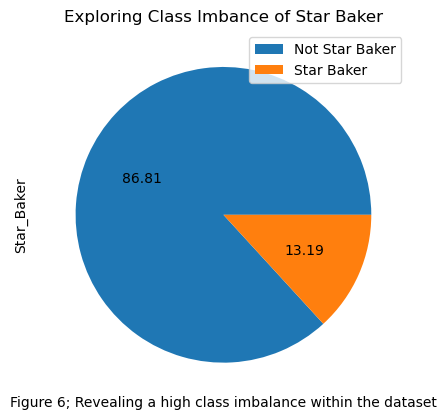

In [19]:
df.Star_Baker.value_counts().plot(kind='pie',labels=['',''],autopct='%.2f')
plt.legend(['Not Star Baker','Star Baker'])
plt.title('Exploring Class Imbance of Star Baker')
text='Figure 6; Revealing a high class imbalance within the dataset'
plt.text(0,-1.3,text,ha='center')

### Dealing with Class Imbalance

We will use 5 methods to deal with class imbalance
1. Do nothing 
2. set Stratify = y to maintain our class ratios between the train/test/split
3. use SMOTE
4. use SMOTETomek
5. use TomekLinks

In [20]:
df.shape

(667, 12)

In [21]:
#establish X and y
X = df.drop(columns='Star_Baker')
y= df['Star_Baker'].values

In [23]:
# We will not set stratify=y and test moethods 1,3,4 and 5 listed above. 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30, random_state=0)

#create unique lists for our different transformed columns
num_cols = list(X_train.select_dtypes(include='number').columns)
cat_cols = list(X_train.select_dtypes(include='category').columns)
sig_text = ('signature')
show_text = ('showstopper')

#add the transformers
preprocessor = ColumnTransformer( 
    transformers = [
        
        ('num',StandardScaler(),num_cols),                         #scale the numerical values
        ('cat',OneHotEncoder(handle_unknown = 'ignore'),cat_cols), #encode the categorical features
        ('text_sig',TfidfVectorizer(max_features=50),sig_text),    #freq counts for words
        ('text_show',TfidfVectorizer(max_features=50),show_text)   #freq counts for words
    ], remainder='passthrough')


#fit and transform our data
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)




## SMOTE method 
s= SMOTE()
##SMOTETomek method
smt= SMOTETomek()
##TomekLinks method
tk= TomekLinks()

#resample our training data 
X_res, y_res= s.fit_resample(X_train_trans, y_train)
X_res1, y_res1= smt.fit_resample(X_train_trans, y_train)
X_res2, y_res2= tk.fit_resample(X_train_trans, y_train)



#create our lm model
lr_model = LogisticRegression()

print("Basic LR Model W/O Class Balancing")
lr_model.fit(X_train_trans,y_train)
ypred_basic=lr_model.predict(X_test_trans) 
print(classification_report(y_test,ypred_basic))
print('--------------------')

print("SMOTE TEST")
lr_model.fit(X_res, y_res)
ypred=lr_model.predict(X_test_trans)
print(classification_report(y_test,ypred))
print('--------------------')

print("SMOTETomek TEST")
lr_model.fit(X_res1, y_res1)
ypred1=lr_model.predict(X_test_trans)
print(classification_report(y_test,ypred1))
print('--------------------')
print("TomekLinks TEST")
lr_model.fit(X_res2, y_res2)
ypred2=lr_model.predict(X_test_trans)
print(classification_report(y_test,ypred2))
print("")
print("")
print("Figure 7; Performance of various class resampling technqiues")

Basic LR Model W/O Class Balancing
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       175
           1       0.48      0.42      0.45        26

    accuracy                           0.87       201
   macro avg       0.70      0.68      0.69       201
weighted avg       0.86      0.87      0.86       201

--------------------
SMOTE TEST
              precision    recall  f1-score   support

           0       0.95      0.85      0.89       175
           1       0.40      0.69      0.51        26

    accuracy                           0.83       201
   macro avg       0.67      0.77      0.70       201
weighted avg       0.88      0.83      0.84       201

--------------------
SMOTETomek TEST
              precision    recall  f1-score   support

           0       0.95      0.84      0.89       175
           1       0.40      0.73      0.52        26

    accuracy                           0.83       201
   macro avg       0.68 

In [24]:
# We will now set stratify=y and test method 2 listed above. 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.30, random_state=0,stratify=y)

#create unique lists for our different transformed columns
num_cols = list(X_train.select_dtypes(include='number').columns)
cat_cols = list(X_train.select_dtypes(include='category').columns)
sig_text = ('signature')
show_text = ('showstopper')

#add the transformers
preprocessor = ColumnTransformer( 
    transformers = [
        
        ('num',StandardScaler(),num_cols),                         #scale the numerical values
        ('cat',OneHotEncoder(handle_unknown = 'ignore'),cat_cols), #encode the categorical features
        ('text_sig',TfidfVectorizer(max_features=50),sig_text),    #freq counts for words
        ('text_show',TfidfVectorizer(max_features=50),show_text)   #freq counts for words
    ], remainder='passthrough')



X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

lr_model_2 = LogisticRegression()

lr_model_2.fit(X_train_trans,y_train)

ypred_strat=lr_model_2.predict(X_test_trans)
print('--------------------')
print("Stratify")
print(classification_report(y_test,ypred_strat))

--------------------
Stratify
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       174
           1       0.47      0.30      0.36        27

    accuracy                           0.86       201
   macro avg       0.68      0.62      0.64       201
weighted avg       0.84      0.86      0.85       201



Ranking these methods for f1-score since there isn't a big difference in False Positives or False negatives in this model

Ranking
1. SMOTETomek (0.50 f1)
2. SMOTE (0.52 f1)
3. TomekLinks (0.47 f1)
4. non-stratify (0.45 f1)
5. stratify (0.45 f1)

####THESE NUMBERS KEEP CHANGING #####

# Model Creation

Now that we know that we want to use SMOTETomke, let's trying subsituting models out to improve our model performance

## RandomForest

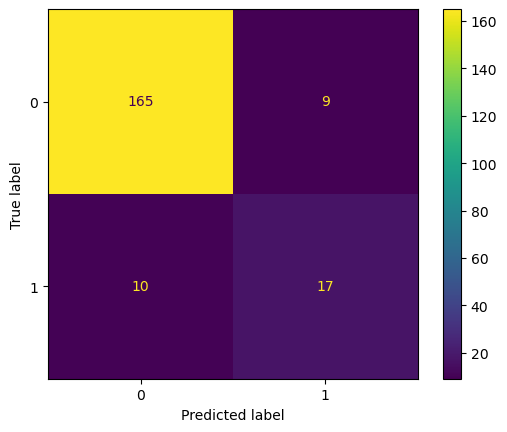

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       174
           1       0.65      0.63      0.64        27

    accuracy                           0.91       201
   macro avg       0.80      0.79      0.79       201
weighted avg       0.90      0.91      0.90       201

The training score for the random forest model is 1.0     
and the testing score for the model is 0.9054726368159204


In [25]:
#Basic Random Forest with SMOTETomke
rf = RandomForestClassifier(random_state = 1, n_jobs=-1)

#fit
model =rf.fit(X_res1, y_res1)

#pred
y_pred = model.predict(X_test_trans)

#confusion matrix

cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()





print(classification_report(y_test,y_pred))

#scores

training_score = (rf.score(X_res1,y_res1))
testing_score = (rf.score(X_test_trans, y_test))
f1 = f1_score(y_pred, y_test)

print(f'The training score for the random forest model is {training_score}\
     \nand the testing score for the model is {testing_score}')

f1 score was raised to 0.67; much better. 

### Creating a table to store model outputs

In [26]:
Model_Data_Frame = pd.DataFrame({"Random Forest w/o CV": [training_score,testing_score,f1]})
index_name = ['Training','Testing','F1']
Model_Data_Frame.index=index_name
Model_Data_Frame

,Random Forest w/o CV
Training,1.000000
Testing,0.905473
F1,0.641509


Fitting 3 folds for each of 100 candidates, totalling 300 fits


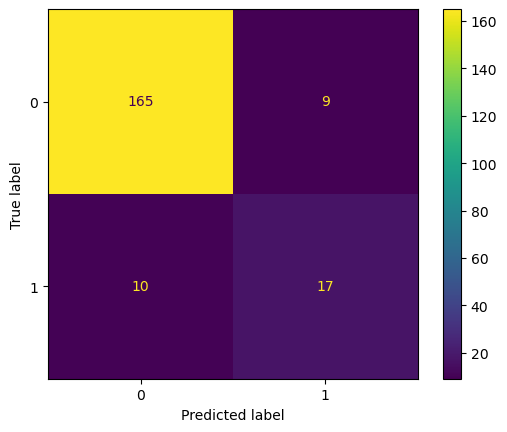

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       174
           1       0.65      0.63      0.64        27

    accuracy                           0.91       201
   macro avg       0.80      0.79      0.79       201
weighted avg       0.90      0.91      0.90       201



In [27]:
#Random Forest with SMOTETomke with hyperparameter tuning



rf = RandomForestClassifier(random_state = 1, n_jobs=-1)


#creating HP tuning Grid


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]


# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}





# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_res1, y_res1)

#pred
y_pred = model.predict(X_test_trans)
#confusion matrix
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

#evaluations
#report card
print(classification_report(y_test,y_pred))

#scores
training_score = (rf_random.score(X_res1,y_res1))
testing_score = (rf_random.score(X_test_trans, y_test))
f1 = f1_score(y_test,y_pred)

#add results to ur table
Model_Data_Frame['Random Forest (w/CV)']=[training_score,testing_score,f1]

## Logistic Regression

In [28]:
#Our original model used a LOGIT model so we can add directly to our table
lr_model.fit(X_res1, y_res1)
training_score = (lr_model.score(X_res1,y_res1))
testing_score = (lr_model.score(X_test_trans, y_test))
y_pred=lr_model.predict(X_test_trans)
f1 = f1_score(y_test,y_pred)



Model_Data_Frame['Logistic Regression (w/o CV)']=[training_score,testing_score,f1]

In [29]:
#LOGIT model with hyperparameter tuning

logreg = LogisticRegression()
param_grid = {'C':np.arange(.1,1.1,.1)}

logreg_cv =GridSearchCV(logreg,param_grid,cv=3)


logreg_cv.fit(X_res1,y_res1)
y_pred = logreg_cv.predict(X_test_trans)

print(classification_report(y_test,y_pred))
training_score = (logreg_cv.score(X_res1,y_res1))
testing_score = (logreg_cv.score(X_test_trans, y_test))
f1 = f1_score(y_pred, y_test)

Model_Data_Frame['Logistic Regression (w/ CV)']=[training_score,testing_score,f1]

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       174
           1       0.44      0.81      0.57        27

    accuracy                           0.84       201
   macro avg       0.70      0.83      0.73       201
weighted avg       0.90      0.84      0.85       201



In [30]:
#LOGIT model with lasso regression

logreg_lasso = LogisticRegression(penalty='l1', solver='liblinear')
param_grid = {'C':np.arange(.1,1.1,.1)}

logreg_cv =GridSearchCV(logreg_lasso,param_grid,cv=3)


logreg_cv.fit(X_res1,y_res1)

y_pred = logreg_cv.predict(X_test_trans)

print(classification_report(y_test,y_pred))
training_score = (logreg_cv.score(X_res1,y_res1))
testing_score = (logreg_cv.score(X_test_trans, y_test))
f1 = f1_score(y_pred, y_test)

Model_Data_Frame['Logistic Regression (w/ CV & Lasso)']=[training_score,testing_score,f1]

              precision    recall  f1-score   support

           0       0.97      0.83      0.89       174
           1       0.43      0.85      0.58        27

    accuracy                           0.83       201
   macro avg       0.70      0.84      0.73       201
weighted avg       0.90      0.83      0.85       201



## Finding out most Important Features

In [43]:
#print out a list of important coefficients
Coef_Table = pd.DataFrame(zip(preprocessor.get_feature_names_out(),
                              logreg_cv.best_estimator_.coef_[0])).sort_values(1,ascending=False)
Coef_Table.columns=['Features','Coef']
Coef_Table =Coef_Table.loc[Coef_Table.Coef>0]
Coef_Table.columns = pd.MultiIndex.from_product([["Lasso Regression"], Coef_Table.columns])
Coef_Table

Lasso Regression          
                       Features      Coef
21         cat__Week_Name_Final  5.387220
127              text_show__pie  2.591604
116               text_show__in  2.036817
122           text_show__mousse  1.732473
45              text_sig__bread  1.697189
4                 num__Favorite  1.472848
105          text_show__churros  1.193118
70                text_sig__pie  1.095122
32         cat__Week_Name_Tarts  0.987632
18       cat__Week_Name_Dessert  0.610653
117          text_show__korovai  0.604411
118            text_show__lemon  0.568904
40                text_sig__and  0.473119
50             text_sig__cheese  0.414155
24        cat__Week_Name_Pastry  0.314949
1      num__Signature_Handshake  0.308700
91               text_show__and  0.281701
25           cat__Week_Name_Pie  0.223971
69              text_sig__pecan  0.180750
109             text_show__filo  0.160954
3    num__Showstopper_Handshake  0.137527
120         text_show__meringue  0.071962
10      cat__Week_Name_Biscuits  0.019654

You can see when we use a lasso regression, that making it to the finals is the most important factor for winning star baker. When in doubt cook with meringue and lemon and do well during Tarts week

C:\Users\Matt\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Text(20, 0.1, 'Figure 9; Determining the ideal number of features')

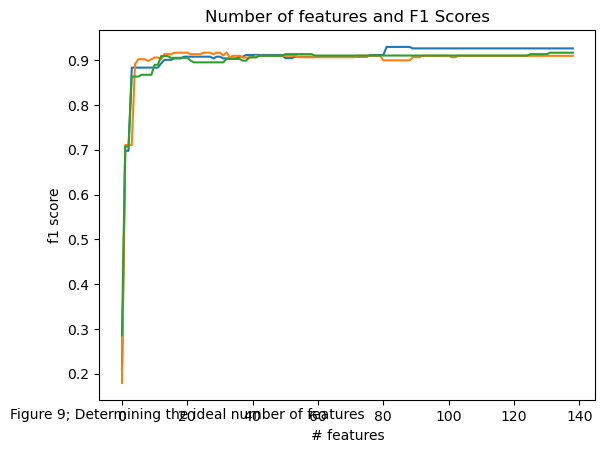

In [32]:
#Trying feature reduction with reductive feature elimination and our logit model
from sklearn.feature_selection import RFECV
selector = RFECV(lr_model, step=1, cv=3,
              scoring='f1')

selector.fit(X_res1,y_res1)

plt.plot(range(len(selector.grid_scores_)),selector.grid_scores_)
plt.title('Number of features and F1 Scores')
plt.xlabel("# features")
plt.ylabel('f1 score')
plt.text(20,.1,'Figure 9; Determining the ideal number of features', ha='center')

Going with n_features as 20

In [44]:
#Recursive Feature Elimination
from sklearn.feature_selection import RFE

selector = RFE(lr_model, n_features_to_select=20)
selector.fit(X_res1,y_res1)


RFE(estimator=LogisticRegression(), n_features_to_select=20)

In [45]:
RFE_df = pd.DataFrame(preprocessor.get_feature_names_out(),selector.ranking_)
RFE_df.reset_index(inplace=True)
RFE_df = pd.concat([RFE_df,pd.DataFrame(selector.estimator.coef_[0])],axis=1)
RFE_df.columns=['Rank','Features','Coef']
RFE_df =RFE_df.loc[RFE_df.Rank==1][['Features','Coef']]
RFE_df = RFE_df.loc[RFE_df.Coef>0].sort_values('Coef',ascending=False)
RFE_df.columns = pd.MultiIndex.from_product([["RFE"], RFE_df.columns])
RFE_df

RFE          
                 Features      Coef
21   cat__Week_Name_Final  3.370200
45        text_sig__bread  1.455459
127        text_show__pie  1.451286
4           num__Favorite  1.375870
116         text_show__in  1.315476
122     text_show__mousse  1.211753
70          text_sig__pie  0.858046
115     text_show__hidden  0.519590

In [46]:
#combine the tables
pd.concat([RFE_df,Coef_Table],axis=1).reset_index(drop=True)

RFE                      Lasso Regression          
                Features      Coef                    Features      Coef
0   cat__Week_Name_Final  3.370200        cat__Week_Name_Final  5.387220
1        text_sig__bread  1.455459             text_sig__bread  1.697189
2         text_show__pie  1.451286              text_show__pie  2.591604
3          num__Favorite  1.375870               num__Favorite  1.472848
4          text_show__in  1.315476               text_show__in  2.036817
5      text_show__mousse  1.211753           text_show__mousse  1.732473
6          text_sig__pie  0.858046               text_sig__pie  1.095122
7      text_show__hidden  0.519590                         NaN       NaN
8                    NaN       NaN          text_show__churros  1.193118
9                    NaN       NaN        cat__Week_Name_Tarts  0.987632
10                   NaN       NaN      cat__Week_Name_Dessert  0.610653
11                   NaN       NaN          text_show__korovai  0.604411
12                   NaN       NaN            text_show__lemon  0.568904
13                   NaN       NaN               text_sig__and  0.473119
14                   NaN       NaN            text_sig__cheese  0.414155
15                   NaN       NaN       cat__Week_Name_Pastry  0.314949
16                   NaN       NaN    num__Signature_Handshake  0.308700
17                   NaN       NaN              text_show__and  0.281701
18                   NaN       NaN          cat__Week_Name_Pie  0.223971
19                   NaN       NaN             text_sig__pecan  0.180750
20                   NaN       NaN             text_show__filo  0.160954
21                   NaN       NaN  num__Showstopper_Handshake  0.137527
22                   NaN       NaN         text_show__meringue  0.071962
23                   NaN       NaN     cat__Week_Name_Biscuits  0.019654

Here is a list of the features that will most likely predict a star baker. While being in the finals makes sense, some valuable insight derrived from this analysis is that you should bake recipes with the word "bread" during the signature challenge, and "pie" during the showstopper challenge. Also, doing well during Tarts week is very important and being labeled a favorite "prior" to the showstopper challenge is a big deal. Aka, its more important to do well on Day 1 than Day 2.

## Gradient Boosting

In [36]:
#Gradient Boosting w/o CV

gb = GradientBoostingClassifier()

gb.fit(X_res1,y_res1)
y_pred = gb.predict(X_test_trans)

training =gb.score(X_res1,y_res1)
testing =gb.score(X_test_trans, y_test)


f1=f1_score(y_test,y_pred)

Model_Data_Frame['Gradient Boosting (w/CV)']=[training,testing,f1]

In [37]:
#Gradient Boosting with CV

#params
learning_rate = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
n_estimators = [18,19,20,21,22]
max_depth = [1,2,3]
params = ({'learning_rate': learning_rate,
          'n_estimators' : n_estimators,
          'max_depth': max_depth})

#model
gb = GradientBoostingClassifier()

cv = GridSearchCV(gb,params, cv=5)

#fit/transform
cv.fit(X_res1,y_res1)

y_pred = cv.predict(X_test_trans)

f1=f1_score(y_test,y_pred)

training =cv.score(X_res1,y_res1)
testing =cv.score(X_test_trans, y_test)

Model_Data_Frame['Gradient Boosting (w/CV)']=[training,testing,f1]

### KNN

In [38]:
simplefilter(action='ignore', category=FutureWarning) # to deal with annoying future warning

In [39]:
#KNN model w/o CV

knn = KNeighborsClassifier()

knn.fit(X_res1,y_res1)


y_pred = knn.predict(X_test_trans)

f1=f1_score(y_test,y_pred)



training =knn.score(X_res1,y_res1)
testing =knn.score(X_test_trans, y_test)


Model_Data_Frame['KNN (w/o CV)']=[training,testing,f1]

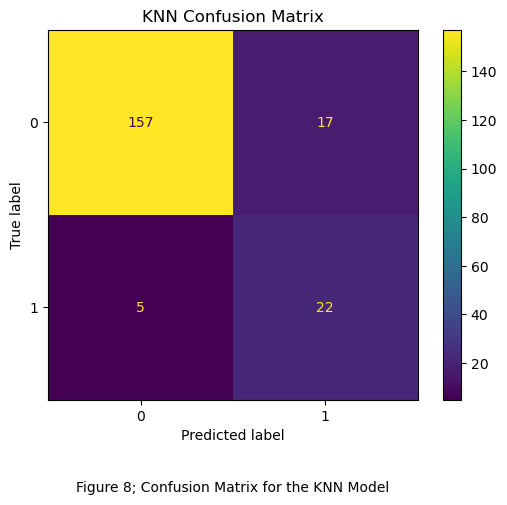

In [48]:
#KNN model w/ CV

#param
param_grid = {'n_neighbors':np.arange(2,50)}

#model
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)

#fit
knn_cv.fit(X_res1,y_res1)
y_pred = knn_cv.predict(X_test_trans)

f1=f1_score(y_test,y_pred)



training =knn_cv.score(X_res1,y_res1)
testing =knn_cv.score(X_test_trans, y_test)


cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
txt='Figure 8; Confusion Matrix for the KNN Model'
plt.text(.5,2,txt,ha='center')
plt.title("KNN Confusion Matrix")
plt.show()




In [51]:
print(classification_report(y_test,y_pred))
Model_Data_Frame['KNN (w/CV)']=[training,testing,f1]

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       174
           1       0.56      0.81      0.67        27

    accuracy                           0.89       201
   macro avg       0.77      0.86      0.80       201
weighted avg       0.91      0.89      0.90       201



In [42]:
#Table of models
Model_Data_Frame.loc['Variance',:] = Model_Data_Frame.loc['Training',:] - Model_Data_Frame.loc['Testing',:]
Model_Data_Frame

,Random Forest w/o CV,Random Forest (w/CV),Logistic Regression (w/o CV),Logistic Regression (w/ CV),Logistic Regression (w/ CV & Lasso),Gradient Boosting (w/CV),KNN (w/o CV),KNN (w/CV)
Training,1.000000,1.000000,0.935644,0.935644,0.928218,0.991337,0.910891,1.000000
Testing,0.905473,0.905473,0.835821,0.835821,0.830846,0.870647,0.805970,0.890547
F1,0.641509,0.641509,0.571429,0.571429,0.575000,0.628571,0.561798,0.666667
Variance,0.094527,0.094527,0.099823,0.099823,0.097372,0.120690,0.104921,0.109453


The KNN model with CV Shows the largest F1 score (0.68) and the lowest variance between training and testing data with 0.1